# Desafío 3

Utilizar otro dataset y poner en práctica la generación de secuencias con las estrategias presentadas.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Datos

Voy a utilizar el dataset movie_reviews de nltk, que contiene 2000 reseñas de películas que fueron extraídas de la página web IMDb.


In [ ]:
import nltk
from nltk.corpus import movie_reviews

nltk.download('movie_reviews')
nltk.download('punkt')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Obtener todas las reseñas
reviews = movie_reviews.raw()

# Tokenizar las reseñas en oraciones
sentences = nltk.sent_tokenize(reviews)

# Crear un DataFrame de pandas
df = pd.DataFrame(sentences).head(5000)

# Mostrar el DataFrame
df


,0
0,"plot : two teen couples go to a church party ,..."
1,they get into an accident .
2,"one of the guys dies , but his girlfriend cont..."
3,what's the deal ?
4,"watch the movie and "" sorta "" find out ."
...,...
4995,"the trio must team together "" as family "" to b..."
4996,there ya go .
4997,not the whole story but no big context clues .
4998,"too much , right ?"


## Modelo de lenguaje con tokenización por palabras

### Elegir el tamaño del contexto

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

(array([888., 699., 826., 963., 604., 403., 279., 141.,  90.,  42.,  34.,
          8.,  10.,   6.,   3.,   2.,   1.,   0.,   0.,   1.]),
 array([  0. ,   5.3,  10.6,  15.9,  21.2,  26.5,  31.8,  37.1,  42.4,
         47.7,  53. ,  58.3,  63.6,  68.9,  74.2,  79.5,  84.8,  90.1,
         95.4, 100.7, 106. ]),
 <BarContainer object of 20 artists>)

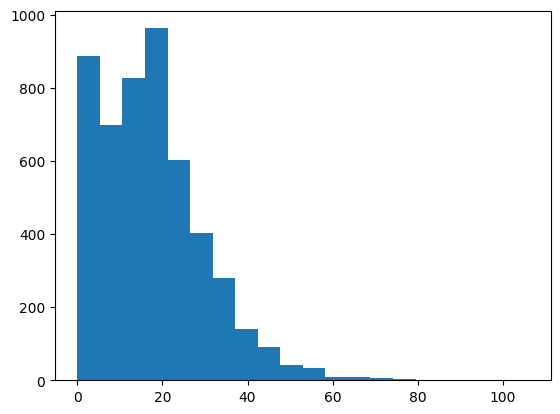

In [ ]:
# cada oración la guardamos en una lista
text = list(df.loc[:,0])

# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 33


### Tokenizar

In [ ]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences[0]

[76, 73, 717, 2785, 125, 5, 2, 5600, 916, 2786, 3, 104, 1092]

In [ ]:
segmented_sentences[0]

['plot',
 'two',
 'teen',
 'couples',
 'go',
 'to',
 'a',
 'church',
 'party',
 'drink',
 'and',
 'then',
 'drive']

### Organizando y estructurando el dataset

In [ ]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)


In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:
  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

tok_sent_augm = []

for sent in tok_sent:
  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [ ]:
train_seqs = np.concatenate(tok_sent_augm, axis=0)
train_seqs

array([[   0,    0,    0, ...,    0,   17,  221],
       [   0,    0,    0, ...,   17,  221,    9],
       [   0,    0,    0, ...,  221,    9,    2],
       ...,
       [   0,    0,    0, ...,   12,    1, 4270],
       [   0,    0,    0, ...,    1, 4270,  781],
       [   0,    0,    0, ..., 4270,  781, 6533]], dtype=int32)

### Definir el modelo

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
model = Sequential()

vocab_size = len(tok.word_counts)

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          571650    
                                                                 
 lstm (LSTM)                 (None, None, 100)         60400     
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 dense (Dense)               (None, None, 11433)       1154733   
                                                                 
Total params: 1867183 (7.12 MB)
Trainable params: 1867183 (7.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("word_model")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
2883/2883 [==============================] - ETA: 0s - loss: 4.1635
 mean perplexity: 15956.670044535711 

Saved new model!
2883/2883 [==============================] - 384s 132ms/step - loss: 4.1635
Epoch 2/20
2883/2883 [==============================] - ETA: 0s - loss: 4.0967
 mean perplexity: 21006.55278732177 

2883/2883 [==============================] - 371s 129ms/step - loss: 4.0967
Epoch 3/20
2883/2883 [==============================] - ETA: 0s - loss: 4.0936
 mean perplexity: 17130.37793355775 

2883/2883 [==============================] - 369s 128ms/step - loss: 4.0936
Epoch 4/20
2883/2883 [==============================] - ETA: 0s - loss: 4.0910
 mean perplexity: 17717.683088960628 

2883/2883 [==============================] - 368s 128ms/step - loss: 4.0910
Epoch 5/20
2883/2883 [==============================] - ETA: 0s - loss: 4.0886
 mean perplexity: 20504.313157903183 

2883/2883 [==============================] - 369s 128ms/step - loss: 4.0886
Epoch 6/20
2883

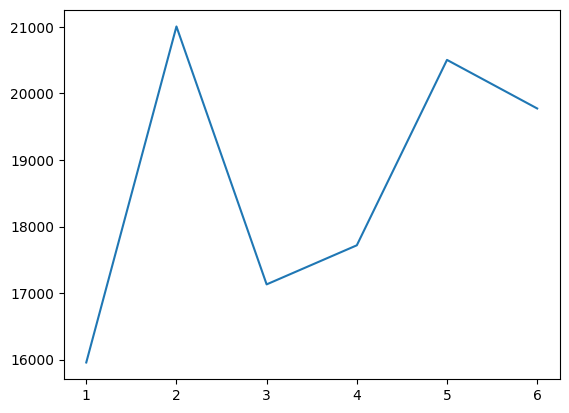

In [ ]:
# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('word_model')

### Predicción con Beam Search

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [ ]:
salidas = beam_search(model,num_beams=20,num_words=5,input="two teen couples go to",temp=1.5,mode='sto')

decode(salidas[0])

["two teen couples go to patrick's"]

In [ ]:
salidas = beam_search(model,num_beams=10,num_words=6,input="though it's an horror movie",temp=1.4,mode='sto')

decode(salidas[0])

["though it's an horror movie dialogue tells everything"]

In [ ]:
salidas = beam_search(model,num_beams=10,num_words=5,input="the film really felt like",temp=1.5,mode='sto')

decode(salidas[0])

['the film really felt like old']

In [ ]:
salidas = beam_search(model,num_beams=20,num_words=4,input="the main character is",temp=1.4,mode='sto')

decode(salidas[0])

['the main character is catching']

In [ ]:
salidas = beam_search(model,num_beams=20,num_words=4,input="watch the movie and",temp=1.4,mode='sto')

decode(salidas[0])

['watch the movie and the performance']

### Conclusiones

- El modelo genera secuencias que en algunos casos son coherentes en cuanto a estructura gramatical, pero presentan problemas de continuidad o significado lógico.
- En varias secuencias, las últimas palabras parecen forzadas o fuera de contexto.
- El modelo podría beneficiarse de una mayor diversidad en el vocabulario y de una representación más rica de las relaciones entre palabras en los datos de entrenamiento (debido a un problema de memoria ram fue necesario recortar el dataset a tan solo 5000 reviews=.

## Modelo de lenguaje con tokenización por caracteres

In [ ]:
reviews = movie_reviews.fileids()
limited_reviews = reviews[:100]
corpus = ' '.join([movie_reviews.raw(fileid).replace('\n', ' ') for fileid in limited_reviews])

corpus

'plot : two teen couples go to a church party , drink and then drive .  they get into an accident .  one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares .  what\'s the deal ?  watch the movie and " sorta " find out . . .  critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package .  which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn\'t snag this one correctly .  they seem to have taken this pretty neat concept , but executed it terribly .  so what are the problems with the movie ?  well , its main problem is that it\'s simply too jumbled .  it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , have n

### Elegir el tamaño del contexto

In [ ]:
# seleccionamos el tamaño de contexto
max_context_size = 50

In [ ]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(corpus)
vocab_size = len(chars_vocab)

In [ ]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}


### Tokenizar

In [ ]:
tokenized_text = [char2idx[ch] for ch in corpus]

### Organizando y estructurando el dataset

In [ ]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

### Definiendo el modelo

In [ ]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 60)          0         
 ributed)                                                        
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 100)         16100     
                                                                 
 dense (Dense)               (None, None, 60)          6060      
                                                                 
Total params: 22160 (86.56 KB)
Trainable params: 22160 (86.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("char_model.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=32)

Epoch 1/20
10054/10057 [============================>.] - ETA: 0s - loss: 2.0820
 mean perplexity: 6.3843802685602515 

Saved new model!
10057/10057 [==============================] - 220s 22ms/step - loss: 2.0820
Epoch 2/20
    7/10057 [..............................] - ETA: 2:59 - loss: 1.9672

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10056/10057 [============================>.] - ETA: 0s - loss: 1.9441
 mean perplexity: 6.19971529902062 

Saved new model!
10057/10057 [==============================] - 219s 22ms/step - loss: 1.9441
Epoch 3/20
10055/10057 [============================>.] - ETA: 0s - loss: 1.9221
 mean perplexity: 6.144960737790622 

Saved new model!
10057/10057 [==============================] - 222s 22ms/step - loss: 1.9221
Epoch 4/20
10056/10057 [============================>.] - ETA: 0s - loss: 1.9108
 mean perplexity: 6.04678184121856 

Saved new model!
10057/10057 [==============================] - 218s 22ms/step - loss: 1.9108
Epoch 5/20
10055/10057 [============================>.] - ETA: 0s - loss: 1.9036
 mean perplexity: 5.998848734602762 

Saved new model!
10057/10057 [==============================] - 214s 21ms/step - loss: 1.9036
Epoch 6/20
10056/10057 [============================>.] - ETA: 0s - loss: 1.8996
 mean perplexity: 6.01071788985472 

10057/10057 [==============================

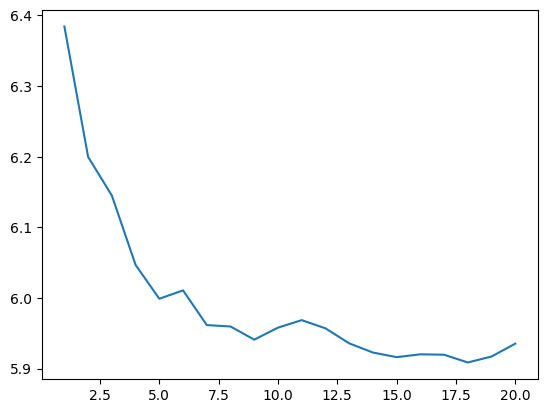

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('char_model.h5')

### Predicción con Beam Search

In [ ]:
def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:
salidas = beam_search(model,num_beams=20,num_words=5,input="two teen couples go to",temp=1.5,mode='sto')

decode(salidas[0])

'two teen couples go to the '

In [ ]:
salidas = beam_search(model,num_beams=10,num_words=6,input="though it's an horror movie the",temp=1.5,mode='sto')

decode(salidas[0])

"though it's an horror movie the stopr"

In [ ]:
salidas = beam_search(model,num_beams=10,num_words=5,input="the film really felt like",temp=1.5,mode='sto')

decode(salidas[0])

'the film really felt like that'

In [ ]:
salidas = beam_search(model,num_beams=20,num_words=4,input="the main character is",temp=1.4,mode='sto')

decode(salidas[0])

'the main character is the'

In [ ]:
salidas = beam_search(model,num_beams=20,num_words=4,input="watch the movie and",temp=1.4,mode='sto')

decode(salidas[0])

'watch the movie and see'

### Conclusiones

- Se observa coherencia desde el punto de vista gramatical. La mayoría de las secuencias generadas son frases válidas:
  - "two teen couples go to the" es coherente aunque incompleta.
  - "the film really felt like that" tiene sentido como una frase completa.

- Aparecen errores tipográficos en algunas secuencias. Estos errores pueden deberse a que el modelo tiene dificultades para generar correctamente palabras completas:
  - "though it's an horror movie the stopr" contiene un error en la palabra "stopr", probablemente una mezcla de "story".

- El modelo tiende a generar palabras comunes o frases frecuentes en el corpus de entrenamiento, como "the" o "that", que pueden no ser las predicciones más adecuadas en algunos contextos.